# Explainability for Jetgraphs with Captum TracIn

In this notebook we show how to apply the Captum TracIn explainability method to some basic Graph Neural Networks (GNNs), making use of the Jetgraph Dataset v5.

Because Captum does not provide an integration with Pytorch Geometric yet, and I realized the code was a bit messy, I moved the overriding and technicalities inside the python package, so that one can just run the explainability method without worrying about them.

## 1. Setup notebook

In [ ]:
# Install necessary packages
!pip install captum
!pip install --user annoy
!pip install pytorch-lightning
!pip install wandb
!pip install git+https://github.com/alessiodevoto/jetgraphs.git

In [1]:
# Some nice features for ipynb to improve plots visualization.
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
torch.manual_seed(12345) # for reproducibility

import warnings
warnings.filterwarnings(
    "ignore", ".*Trying to infer the `batch_size` from an ambiguous collection.*"
)

## 2. Train a model
In order to apply Captum, we need a model trained on the dataset first. We must download the dataset *with the settings we want* and instantiate the model. 

For the dataset, we use the class defined in  `JetgraphDataset.py `. For the model, we can either pick any model from Pytorch Geometric or use one of the pre-defined ones in  `models.py`. 

### 2.1 Download dataset
In the next lines we download the dataset with specific settings

In [2]:
from jetgraphs.JetGraphDataset import JetGraphDatasetInMemory_v2
from jetgraphs.transforms import BuildEdges, OneHotEncodeLayer
from torch_geometric.transforms import Compose, LargestConnectedComponents
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split


# Where data is to be downloaded and stored.
datasets_root = "/Users/alessiodevoto/Downloads/datasets/" 
# secret url to dataset.
raw_data_url = ""

# In the next lines we define how we build the dataset's edges and graph.

# As discussed, we stick to 0.6x0.6 thresholds for the edges.
edge_builder = BuildEdges(
    directed=False, 
    self_loop_weight=1,
    same_layer_threshold=0.6, 
    consecutive_layer_threshold=0.6,
    distance_p=2)

# We extract the main subgraph for each graph and one hot encode the layer.
transforms = Compose([
    LargestConnectedComponents(num_components=1),
    OneHotEncodeLayer()
    ])

# Finally download the dataset.
jet_graph_dataset = JetGraphDatasetInMemory_v2(
    root = datasets_root,       # directory where to download data 
    url = raw_data_url,         # url to raw data
    subset = '10%',            # which subset of the intial 100k graph to consider, default is 100%
    min_num_nodes = 2,          # only include graphs with at least 2 nodes 
    transform =  transforms,
    pre_transform = edge_builder) # edge_builder should be passed as pre_transform to keep data on disk.

# Create the dataloaders.
train_idx, test_idx = train_test_split(range(len(jet_graph_dataset)), stratify=[m.y[0].item() for m in jet_graph_dataset], test_size=0.25)
train_loader = DataLoader(jet_graph_dataset[train_idx], batch_size=32, num_workers=8, shuffle=True)
test_loader = DataLoader(jet_graph_dataset[test_idx], num_workers=8, batch_size=32)


/Users/alessiodevoto/opt/anaconda3/envs/gnns/lib/python3.9/site-packages/torch_geometric/data/dataset.py:150: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete '/Users/alessiodevoto/Downloads/datasets/processed' first
  warnings.warn(


Loaded dataset with name min_nodes_2, containing subset of 10%


### 2.2 Instantiate model

In [3]:
# Instantiate a model. 
# We take it from jetgraphs.models, but it can be any model for pytorch lightning.
from jetgraphs.models import Shallow_GCN

model = Shallow_GCN(hidden_channels=32, node_feat_size=jet_graph_dataset[0].x.shape[1])
model 

Shallow_GCN(
  (loss): BCEWithLogitsLoss()
  (norm): BatchNorm(7)
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)

### 2.3 Train

When training a model we need to provide a directory where to store checkpoints.

In [8]:
import pytorch_lightning as ptlight

# Provide directory to store checkpoints and train (maybe move training inside package?)
chkpt_dir = './checkpoints/'

# We save checkpoints every 50 epochs 
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath=chkpt_dir,
    filename='gnn-{epoch:02d}',
    every_n_epochs=5,
    save_top_k=-1)

# Define trainer.
epochs = 20
trainer = ptlight.Trainer(
    default_root_dir=chkpt_dir, 
    max_epochs=epochs, 
    callbacks=[checkpoint_callback],
    enable_progress_bar=True)

# Train model.
trainer.fit(model, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alessiodevoto/opt/anaconda3/envs/gnns/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /Users/alessiodevoto/projects/jetgraphs_workspace/jetgraphs/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | norm  | BatchNorm         | 14    
2 | conv1 | GCNConv           | 256   
3 | conv2 | GCNConv           | 1.1 K 
4 | conv3 | GCNConv           | 1.1 K 
5 | conv4 | GCNConv           | 1.1 K 
6 | lin   | Linear            | 33    
--------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model par

Sanity Checking: 0it [00:00, ?it/s]

/Users/alessiodevoto/opt/anaconda3/envs/gnns/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## 3. Run Captum TracIn
Once we have the model checkpoints saved, we can run Captum TracIn. 
Please recall that Captum TracIn has two implementations: the fast one, that works on all models, and the complete one, that does not work on ArmaConv and GatConv.

### Method 1 

In [ ]:
from jetgraphs.explainability import CaptumPipeline

pipeline = CaptumPipeline(
    model=model,
    checkpoint_dir=chkpt_dir,
    dataset=jet_graph_dataset,
    train_idx=train_idx,
    epochs=epochs
)

pipeline.run_captum(test_influence_indices=test_idx[:4])


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/alessiodevoto/opt/anaconda3/envs/gnns/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/y0/wb0c3ftn4tb9y626dql717d80000gn/T/ipykernel_2050/3183313609.py", line 1, in <cell line: 1>
    pipeline.display_results(save_to_dir='./')
  File "/Users/alessiodevoto/projects/jetgraphs_workspace/jetgraphs/jetgraphs/explainability.py", line 426, in display_results
    display_proponents_and_opponents(
  File "/Users/alessiodevoto/projects/jetgraphs_workspace/jetgraphs/jetgraphs/explainability.py", line 347, in display_proponents_and_opponents
    plt.savefig(os.path.join(save_to_dir, f"sample_num_{sample_num}.pdf"))
  File "/Users/alessiodevoto/opt/anaconda3/envs/gnns/lib/python3.9/site-packages/matplotlib/pyplot.py", line 980, in savefig
    fig.canvas.draw_idle()   # need this if 'transparent=True' to reset colors
  File "/Users/alessiod

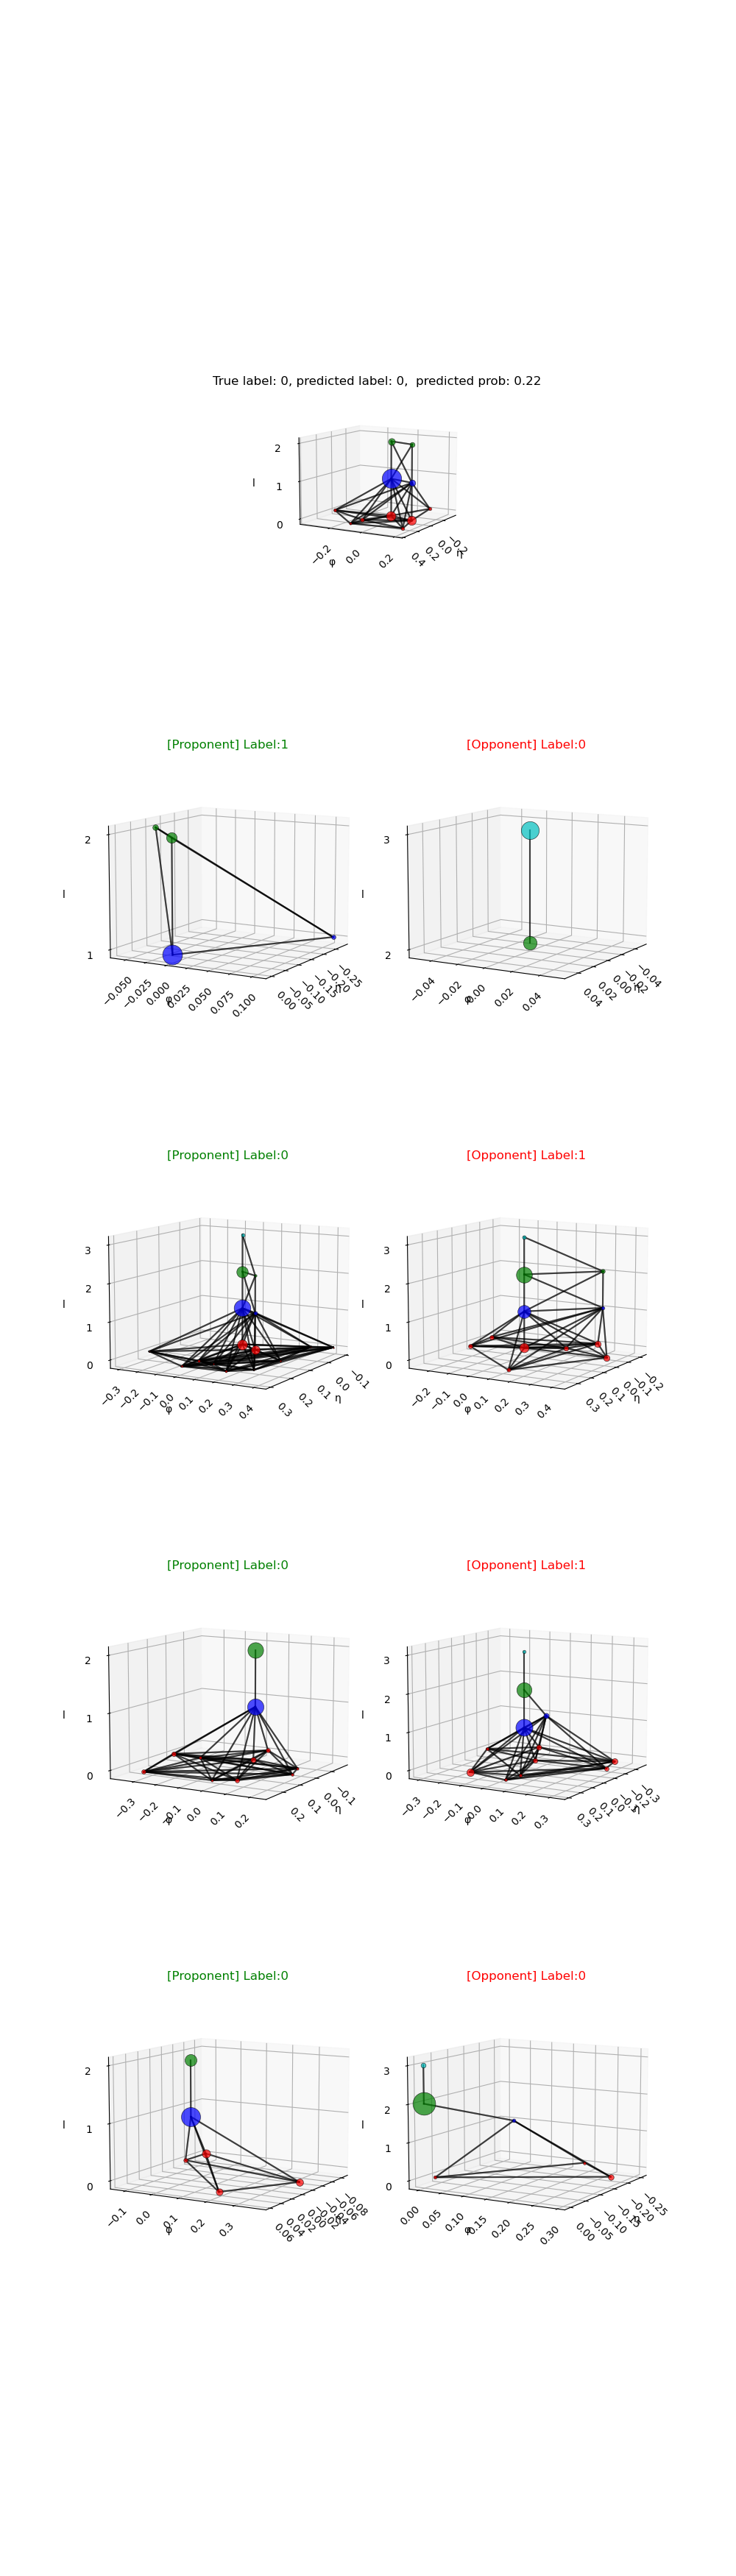

In [139]:
pipeline.display_results(save_to_dir='./')


### Method 2

In [7]:
# We import captum from the jetgraphs repo.
from jetgraphs.explainability import TracInCPFastGNN, TracInCPGNN, checkpoints_load_func
import os.path as osp
import datetime

# We first load the model with the last checkpoint so that the predictions we make in the next cell will be for the trained model.
correct_dataset_final_checkpoint = osp.join(chkpt_dir, f'gnn-epoch={epochs-1}.ckpt')
checkpoints_load_func(model, correct_dataset_final_checkpoint)


# Dataloader for Captum.
influence_src_dataloader = DataLoader(jet_graph_dataset[train_idx], batch_size=64, shuffle=False)


# Run Captum
tracin_cp_fast_gnn = TracInCPFastGNN(
    model=model,
    final_fc_layer=list(model.children())[-1],
    influence_src_dataset=influence_src_dataloader,
    checkpoints=chkpt_dir,
    checkpoints_load_func=checkpoints_load_func,
    loss_fn=torch.nn.functional.binary_cross_entropy_with_logits,
    batch_size=2048,
    vectorize=False,
)

# Prepare samples.
test_influence_indices = test_idx[:4]  # Just consider the first 4 examples in test dataset
test_influence_loader = DataLoader(jet_graph_dataset[test_influence_indices], batch_size=len(test_influence_indices), shuffle=False)
test_examples_batch = next(iter(test_influence_loader))
test_examples_predicted_probs = torch.sigmoid(model(test_examples_batch)) 
test_examples_predicted_labels = (test_examples_predicted_probs > 0.5).float()
test_examples_true_labels = test_examples_batch.y.unsqueeze(1)

k = 4

start_time = datetime.datetime.now()

# Compute proponents.
proponents_indices_fast, proponents_influence_scores_fast = tracin_cp_fast_gnn.influence(
    inputs = test_examples_batch, 
    targets = test_examples_true_labels, 
    k=k, 
    proponents=True, 
    unpack_inputs=False
)


# Compute opponents.
opponents_indices_fast, opponents_influence_scores_fast = tracin_cp_fast_gnn.influence(
    inputs = test_examples_batch, 
    targets = test_examples_true_labels, 
    k=k, 
    proponents=False, 
    unpack_inputs=False
)

total_minutes = (datetime.datetime.now() - start_time).total_seconds() / 60.0

print(
    "Computed proponents / opponents over a dataset of %d examples in %.2f minutes"
    % (len(influence_src_dataloader)*influence_src_dataloader.batch_size, total_minutes)
)

Computed proponents / opponents over a dataset of 7552 examples in 0.44 minutes


We can display the results in terms of proponents and opponents, leveraging the  `plot_jet_graph ` function.


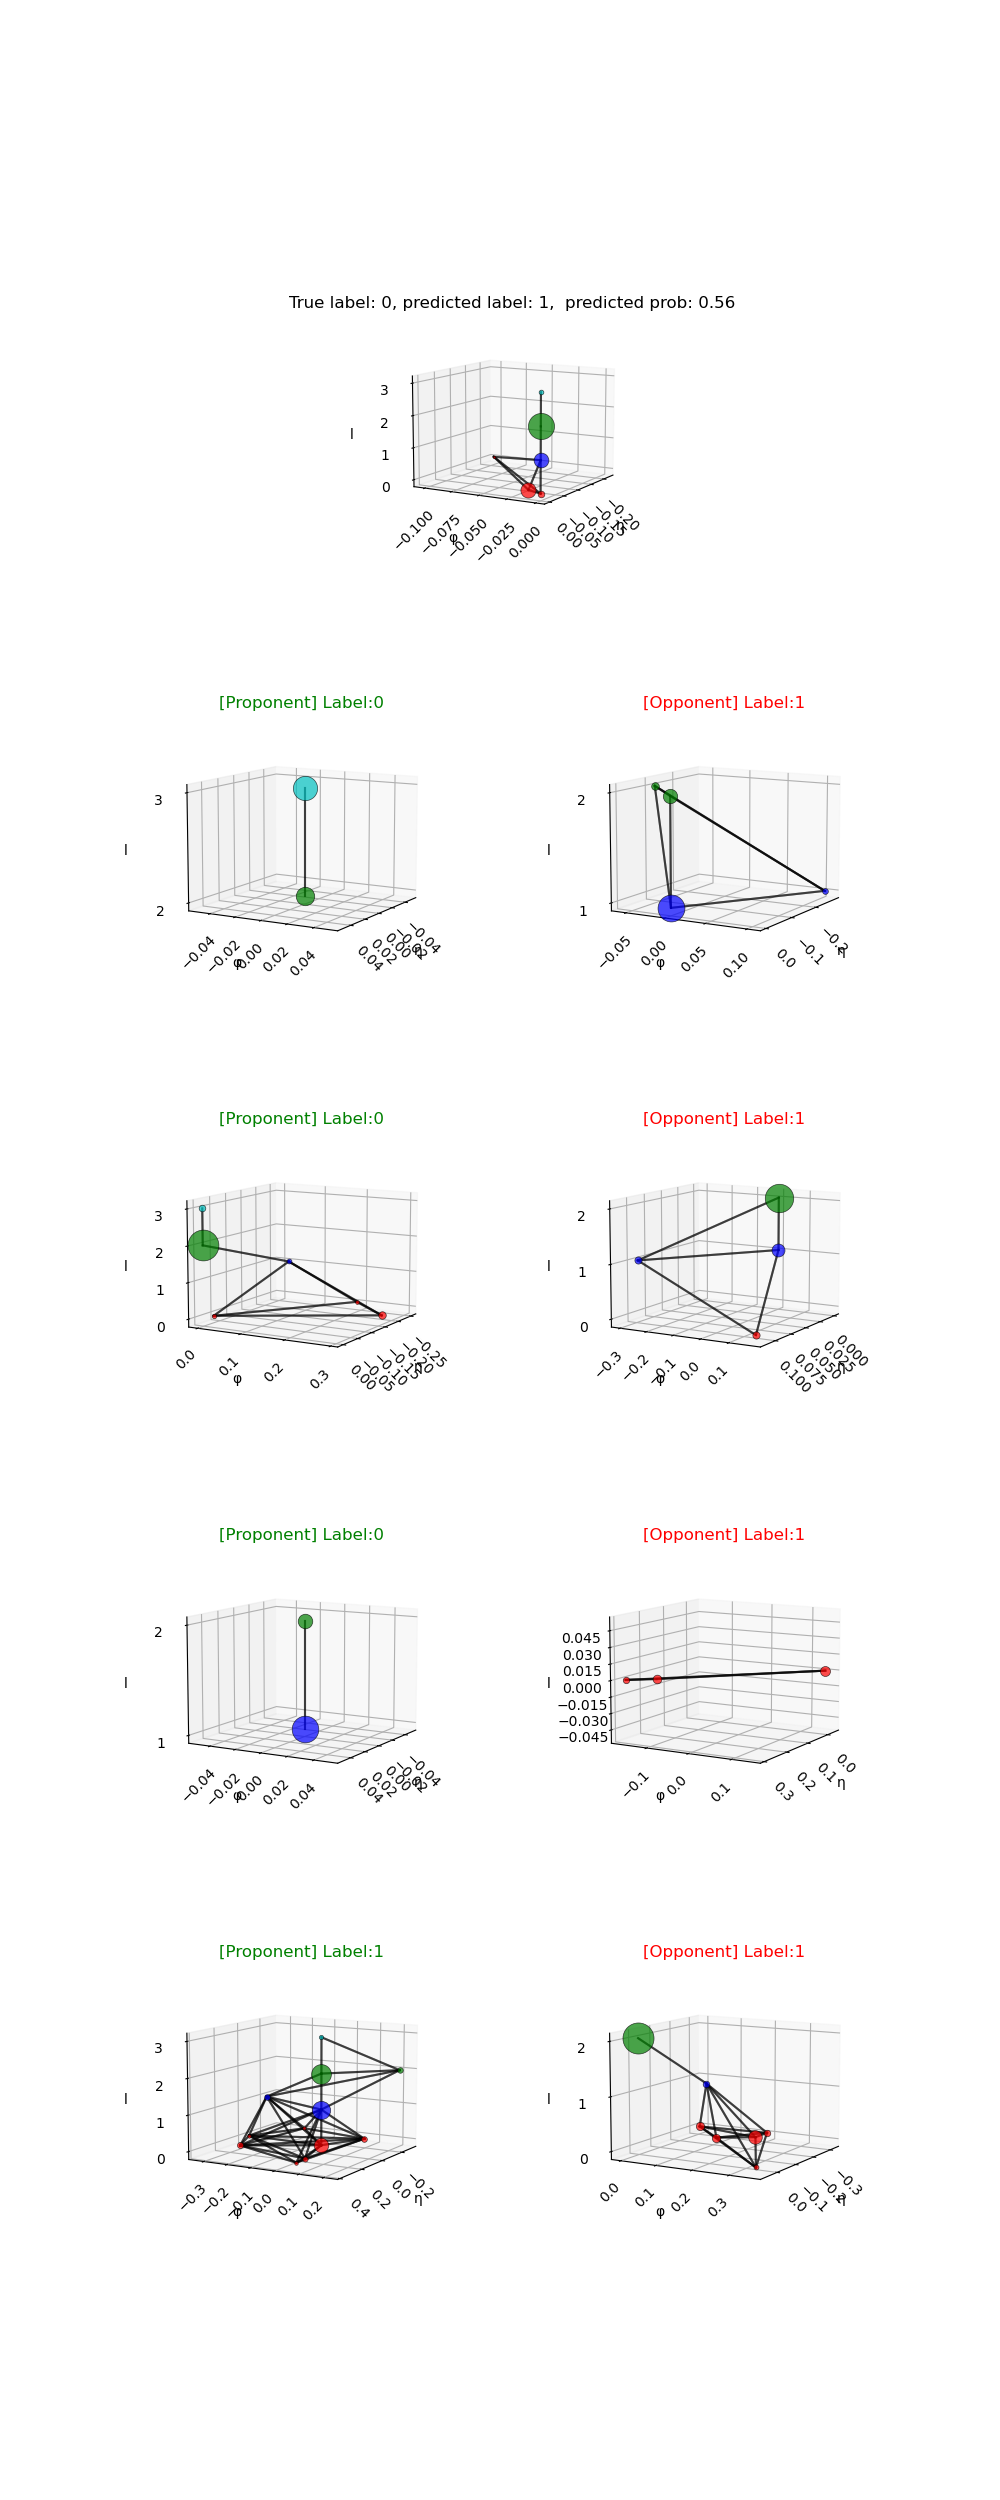

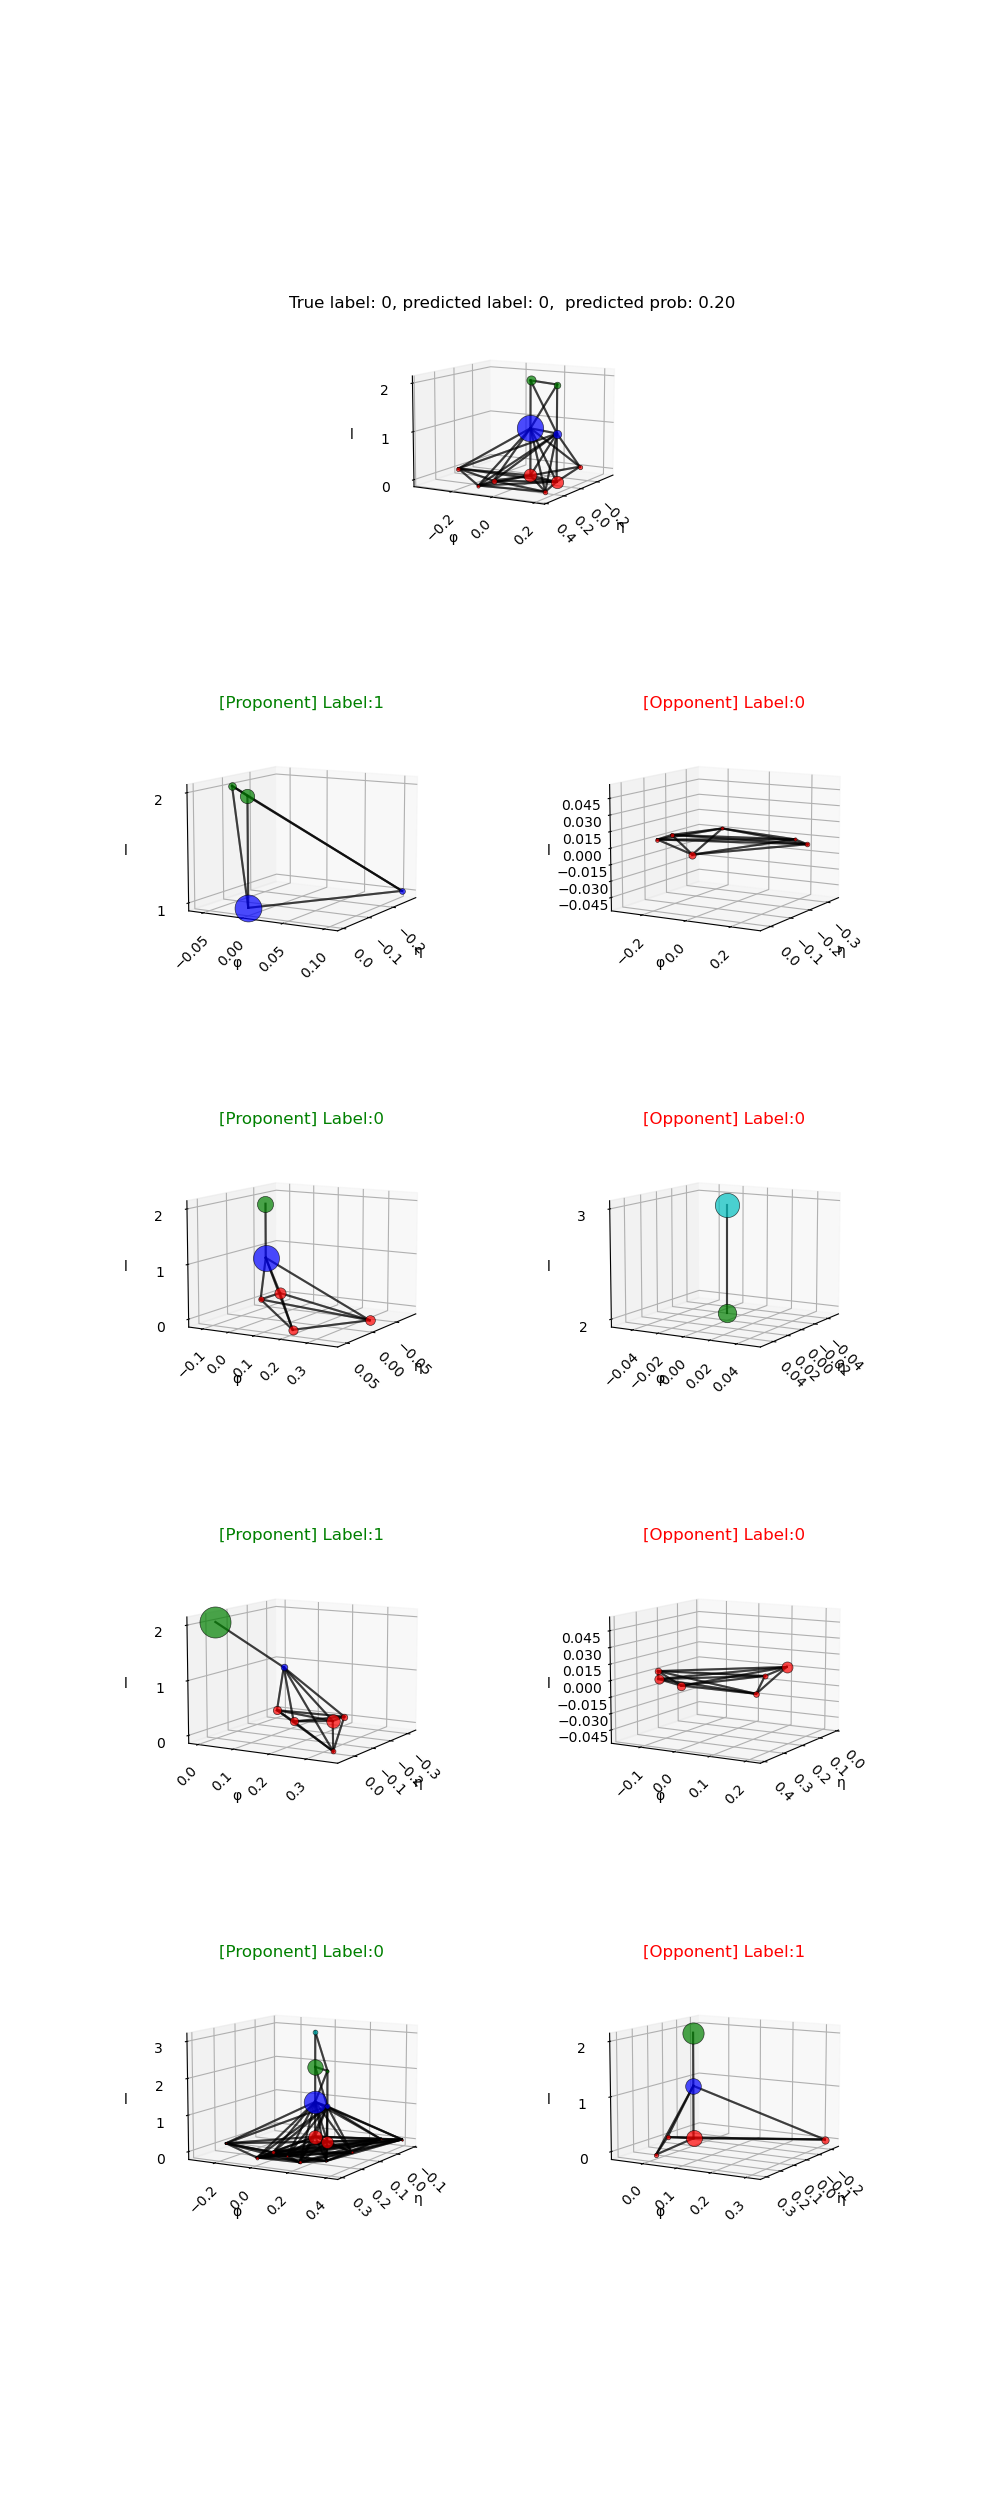

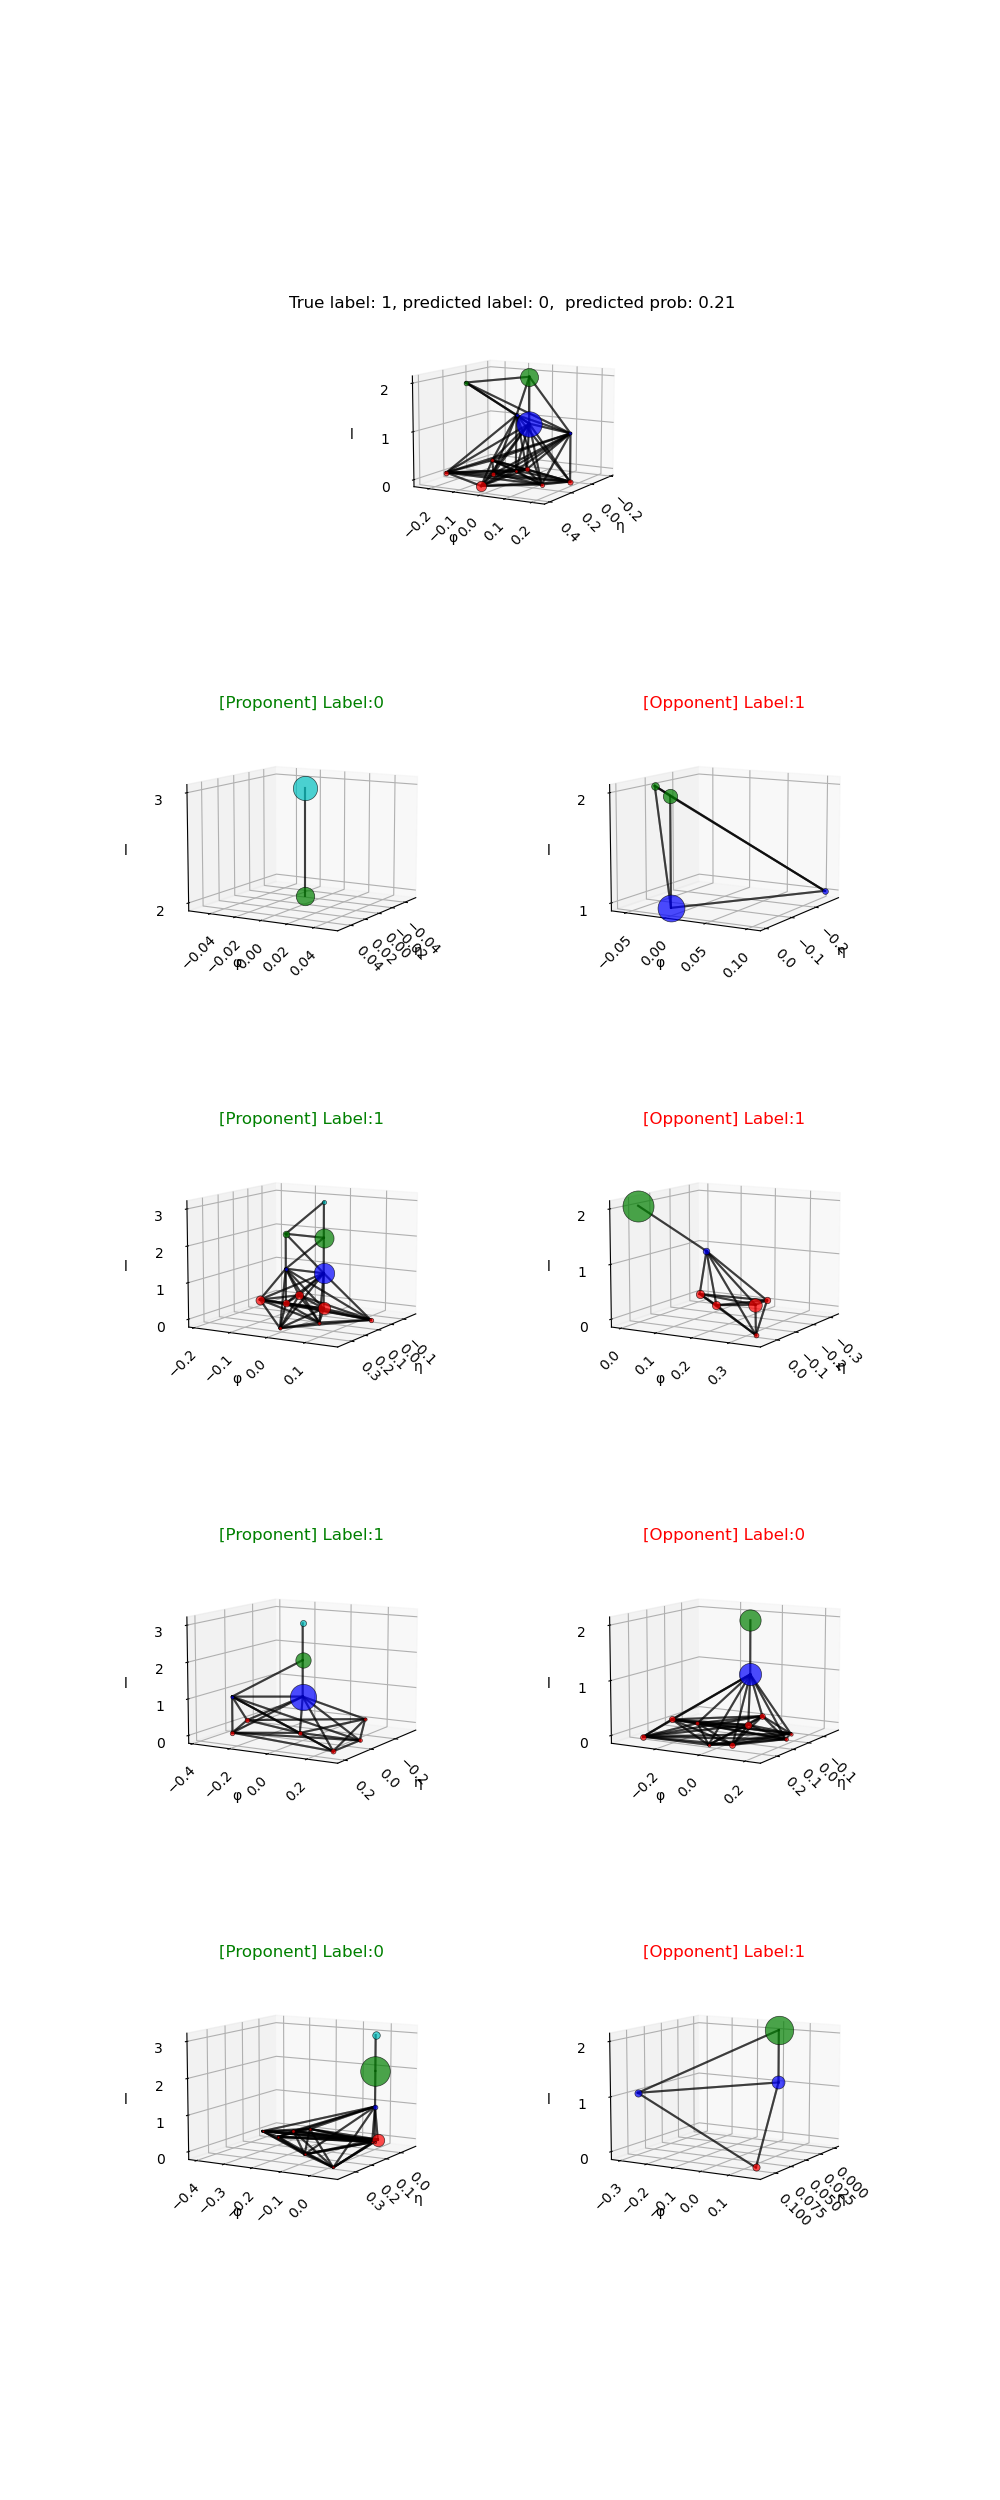

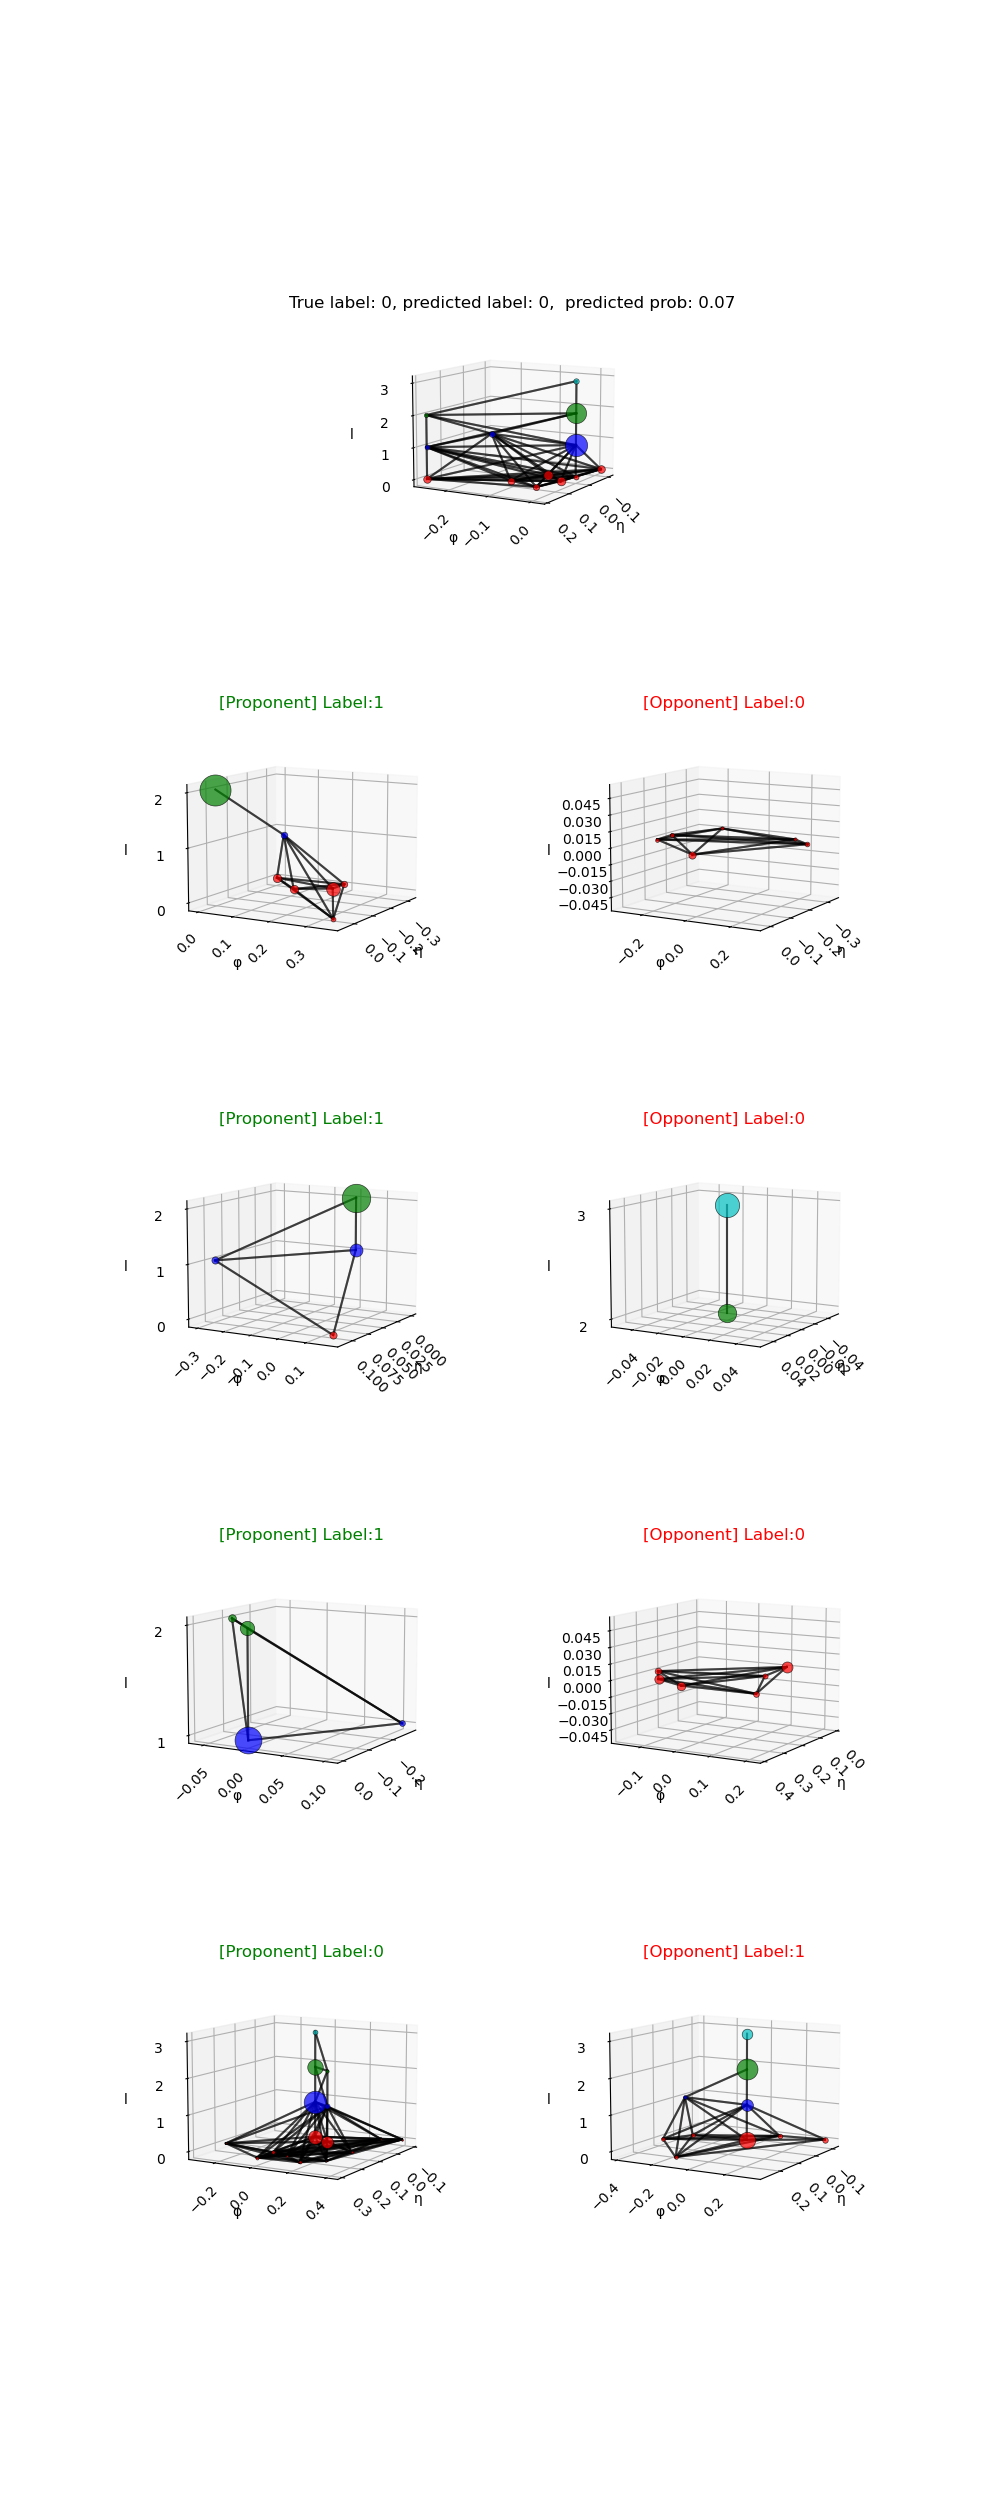

In [124]:
# Display results
from jetgraphs.explainability import display_proponents_and_opponents

# Reconstruct the correct dataset from dataloder
src_dataset = []
for x in influence_src_dataloader:
  src_dataset.extend(x.to_data_list())


display_proponents_and_opponents(
  test_examples_batch.to_data_list(),
  src_dataset,
  test_examples_true_labels,
  test_examples_predicted_labels,
  test_examples_predicted_probs,
  proponents_indices_fast,
  opponents_indices_fast
)
